In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import h5py
np.random.seed(42)

def softmax(Z):
    Z = np.clip(Z, -500, 500) 
    exp_Z=np.exp(Z-np.max(Z,axis=0,keepdims=True))
    A=exp_Z/np.sum(exp_Z,axis=0,keepdims=True)
    cache=Z
    return A,cache
 

   
def sigmoid(Z):
    """
    Implements sigmoid non linear activation to linear output
    Z-> linear output
    """
    Z = np.clip(Z, -500, 500)
    A=1/(1+np.exp(-Z))
    cache=Z
    return A,cache

def relu(Z):
    """
    Implements relu non linear activation to linear output
    Z-> linear output
    """
    A=np.maximum(0,Z)
    cache=Z
    return A,cache

def tanh(Z):
    """
    Implements tanh non linear activation to linear output
    Z-> linear output
    """
    A=np.tanh(Z)
    cache=Z
    return A,cache

def initialize_parameters(layer_dims):
    """ 
    "layer dims" is a list consiting of number of input features and hidden units in each layer
    initalize_parameters() initializes parameters of all hidden layers 

    >>> initalize_parameters([4,10,15,25,10])
            return parameters
    """
    
    np.random.seed(42)
    L=len(layer_dims)
    parameters={}

    
    for i in range(1,L):
        
        parameters["W"+str(i)]=np.random.randn(layer_dims[i],layer_dims[i-1])*np.sqrt(2/layer_dims[i-1])
        parameters["b"+str(i)]=np.zeros((layer_dims[i],1))
        
        assert(parameters["W"+str(i)]).shape==(layer_dims[i],layer_dims[i-1])
        assert(parameters["b"+str(i)]).shape==(layer_dims[i],1)
        
    return parameters
def linear_activation_layer(A_prev,W,b,activation):

    """
    linear_activation_layer has four parameters X,W,b,activatuion
    A_prev-> input feature matrix
    W-> weight matirx
    b-> bias matrix
    activation-> applied non-linearity
    
    """
    Z=np.matmul(W,A_prev)+b
    linear_cache=(A_prev,W,b)
    
    if activation=="relu":
        A,activation_cache=relu(Z)
        
    elif activation=="sigmoid":
        A,activation_cache=sigmoid(Z)
        
    elif activation=="tanh":
        A,activation_cache=tanh(Z)
    elif activation=='softmax':
        A,activation_cache=softmax(Z)
        
    cache=(linear_cache,activation_cache)
    assert(Z.shape==A.shape)
    assert(A.shape==(W.shape[0],A_prev.shape[1]))
    return A,cache   
    

def L_layer_deep_forward_layer(X,parameters):
    """ 
    L_layer_deep_forward_layer implements forward propagation part of Neural Netwrok
    X -> input feature matrix
    parameters -> A set containing all weight matrix and bias vector
    
    """

    
    L=len(parameters)//2
    A_in=X
    caches=[]
    
    for i in range(1,L):
        A_out,cache=linear_activation_layer(A_in,parameters["W"+str(i)],parameters["b"+str(i)],"relu")
        A_in=A_out
        caches.append(cache)
        
    A_L,cache=linear_activation_layer(A_in,parameters["W"+str(L)],parameters["b"+str(L)],"softmax")
    caches.append(cache)
    
    return A_L,caches
    
def compute_cost(y,y_pred):
    """
    Implement the sparse categorical crossentropy function 
    y-> target label
    y_pred-> predicted label
    
    """
    m=y.shape[1]
    logistic_probs=y_pred[y.flatten(),np.arange(m)]
    loss=-np.log(logistic_probs+1e-15)
    
    cost=np.mean(loss)
    cost=np.squeeze(cost)
    return cost

def linear_backward(dZ,linear_cache):
    """
    Implement 'single layer' linear backpropagation 
    dZ-> gradient of cost function w.r.t to linear output
    cache-> it is a tuple coming from linear activation layer 
    
    """
    m=dZ.shape[1]
    A_prev,W,b=linear_cache
    
    dW=np.matmul(dZ,A_prev.T)/m
    db=np.mean(dZ,axis=1,keepdims=True)
    dA_prev=np.matmul(W.T,dZ)
    
    return dW,db,dA_prev
def softmax_backward(y,activation_cache):
    m=y.shape[1]
    Z=activation_cache
    exp_Z=np.exp(Z-np.max(Z,axis=0,keepdims=True))
    A=exp_Z/np.sum(exp_Z,axis=0,keepdims=True)
    dZ=A.copy()
    dZ[y.flatten(),np.arange(m)]-=1
    return dZ
def sigmoid_backward(dA,activation_cache):
    Z=activation_cache
    
    Z = np.clip(Z, -500, 500)
    A=1/(1+np.exp(-Z))
 
    return dA*A*(1-A)

def relu_backward(dA,activation_cache):
    Z=activation_cache
    return dA*np.where(Z>0,1,0)

def tanh_backward(dA,activation_cache):
    Z=activation_cache
    return dA*(1-np.tanh(Z)**2)

def linear_activation_backward(dA,cache,activation,y=None):
    linear_cache,activation_cache=cache
    
    if activation=="relu":
        dZ=relu_backward(dA,activation_cache)
        
    elif activation=="sigmoid":
        dZ=sigmoid_backward(dA,activation_cache)
        
        
    elif activation=="tanh":
        dZ=tanh_backward(dA,activation_cache)
    
    elif activation=='softmax':
        dZ=softmax_backward(y,activation_cache)
    dW,db,dA_prev=linear_backward(dZ,linear_cache)  
    return dW,db,dA_prev


def L_layer_backward(A_L,y,caches):
    grads={}
    L=len(caches)
    cache=caches[L-1]
    m=y.shape[0]
    
  
    grads["dW"+str(L)],grads["db"+str(L)],grads["dA"+str(L-1)]=linear_activation_backward(None,cache,"softmax",y)
 
    
    for i in reversed(range(L-1)):
        
        cache=caches[i]
     
        grads["dW"+str(i+1)],grads["db"+str(i+1)],grads["dA"+str(i)]=linear_activation_backward(grads["dA"+str(i+1)],cache,"relu")
        
    
    return grads


def update_parameters(parameters,grads,learning_rate):
    L=len(parameters)//2
    for i in range (L):
        parameters["W"+str(i+1)]-=learning_rate*grads["dW"+str(i+1)]
        parameters["b"+str(i+1)]-=learning_rate*grads["db"+str(i+1)]
    return parameters
def accuracy_of_model(X,y,parameters):
    m=y.shape[1]
    y_pred,cache= L_layer_deep_forward_layer(X,parameters)
    y_pred=np.argmax(y_pred,axis=0)
    y_true=y.flatten()
    count=np.sum(y_true==y_pred)
    accuracy=count/m

    return (accuracy)
def random_mini_batches(X,y,mini_batch_size,seed):
    np.random.seed(seed)
    mini_batches=[]
    m=X.shape[1]
    
    permutation=list(np.random.permutation(m))
    random_X=X[:,permutation]
    random_y=y[:,permutation]
    
    num_complete_batch=(m//mini_batch_size)
    
    for k in range(num_complete_batch):
        mini_batch_X=random_X[:,k*mini_batch_size:(k+1)*mini_batch_size]
        mini_batch_y=random_y[:,k*mini_batch_size:(k+1)*mini_batch_size]
        
        batch=(mini_batch_X,mini_batch_y)
        mini_batches.append(batch)
        
    if(m%mini_batch_size!=0):
        mini_batch_X=random_X[:,num_complete_batch*mini_batch_size:]
        mini_batch_y=random_y[:,num_complete_batch*mini_batch_size:]
        batch=(mini_batch_X,mini_batch_y)
        mini_batches.append(batch)
        
    return mini_batches
def initialize_velocity(parameters):
    L=len(parameters)//2
    v={}
    for i in range(L):
        v["dW"+str(i+1)]=np.zeros((parameters["W"+str(i+1)].shape[0],parameters["W"+str(i+1)].shape[1]))
        v["db"+str(i+1)]=np.zeros((parameters["b"+str(i+1)].shape[0],parameters["b"+str(i+1)].shape[1]))
    return v

def update_parameters_with_momentum(parameters,grads,v,beta,learning_rate):
    L=len(parameters)//2
    for l in range(L):
        v["dW"+str(l+1)]=beta* v["dW"+str(l+1)] + (1-beta)* grads["dW"+str(l+1)]
        v["db"+str(l+1)]=beta* v["db"+str(l+1)] + (1-beta)* grads["db"+str(l+1)]
        
        parameters["W"+str(l+1)]-=learning_rate*v["dW"+str(l+1)]
        parameters["b"+str(l+1)]-=learning_rate*v["db"+str(l+1)]
    return parameters,v

def initialize_Adam(parameters):
    L=len(parameters)//2
    v={}
    s={}
    for l in range(L):
        v["dW"+str(l+1)]=np.zeros((parameters["W"+str(l+1)].shape[0], parameters["W"+str(l+1)].shape[1]))
        v["db"+str(l+1)]=np.zeros((parameters["b"+str(l+1)].shape[0], parameters["b"+str(l+1)].shape[1]))

        s["dW"+str(l+1)]=np.zeros((parameters["W"+str(l+1)].shape[0], parameters["W"+str(l+1)].shape[1]))
        s["db"+str(l+1)]=np.zeros((parameters["b"+str(l+1)].shape[0], parameters["b"+str(l+1)].shape[1]))
    return v,s

def update_parameters_with_adam(parameters,grads,v,s,t,learning_rate=0.01,beta1=0.9,beta2=0.999,epsilon=1e-8):
    
    v_corrected={}
    s_corrected={}
    
    L=len(parameters)//2
    
    for l in range(L):
        v["dW"+str(l+1)]=beta1*v["dW"+str(l+1)]+(1-beta1)*grads["dW"+str(l+1)]
        v["db"+str(l+1)]=beta1*v["db"+str(l+1)]+(1-beta1)*grads["db"+str(l+1)]
        
        s["dW"+str(l+1)]=beta2*s["dW"+str(l+1)]+(1-beta2)*np.square(grads["dW"+str(l+1)])
        s["db"+str(l+1)]=beta2*s["db"+str(l+1)]+(1-beta2)*np.square(grads["db"+str(l+1)])

        v_corrected["dW"+str(l+1)]=v["dW"+str(l+1)]/(1-beta1**t)
        v_corrected["db"+str(l+1)]=v["db"+str(l+1)]/(1-beta1**t)
        s_corrected["dW"+str(l+1)]=s["dW"+str(l+1)]/(1-beta2**t)
        s_corrected["db"+str(l+1)]=s["db"+str(l+1)]/(1-beta2**t)

        parameters["W"+str(l+1)]-=learning_rate*v_corrected["dW"+str(l+1)]/np.sqrt(s_corrected["dW"+str(l+1)]+epsilon)
        parameters["b"+str(l+1)]-=learning_rate*v_corrected["db"+str(l+1)]/np.sqrt(s_corrected["db"+str(l+1)]+epsilon)
    return parameters,v,s

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np

X, y = load_breast_cancer(return_X_y=True)

scaler = StandardScaler()
X = scaler.fit_transform(X)

y = y.reshape(-1, 1)  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


X_train = X_train.T  
y_train = y_train.T  
X_test = X_test.T
y_test = y_test.T

In [2]:
def model(X,y,layer_dims,optimizer,learning_rate=0.0007,mini_batch_size=64,beta=0.9,beta1=0.9,beta2=0.999,epsilon=1e-8,num_epochs=10000,print_cost=True):

    parameters=initialize_parameters(layer_dims)
    L=len(parameters)//2
    costs=[]
    t=0
    seed=1
    m=y.shape[1]
    
    print(f"The number of training example is: {m}")
    print(f"The size of mini batch for each epoch is: {mini_batch_size}")
    
    
    if optimizer=="GD":
        pass
    elif optimizer=="momentum":
        v=initialize_velocity(parameters)
    elif optimizer=="Adam":
        v,s=initialize_Adam(parameters)
    
    for i in range(num_epochs):
        seed=seed+1
        mini_batches=random_mini_batches(X,y,mini_batch_size,seed)
        total_cost=0

        for mini_batch in mini_batches:
            random_X,random_y=mini_batch
            
            AL,caches=L_layer_deep_forward_layer(random_X,parameters)
            total_cost+=compute_cost(random_y,AL)
            grads=L_layer_backward(AL,random_y,caches)

            if optimizer=="GD":
               
                 parameters = update_parameters(parameters, grads, learning_rate)
            elif optimizer=="momentum":
                parameters,v=update_parameters_with_momentum(parameters,grads,v,beta,learning_rate)
                
            elif optimizer=="Adam":
                t+=1
                parameters,v,s=update_parameters_with_adam(parameters,grads,v,s,t,learning_rate,beta1,beta2,epsilon)
        cost_avg=total_cost/len(mini_batches)
            
        if i%100==0:
            costs.append(cost_avg)
     
        if i % 100 == 0 and print_cost:
            train_accuracy = accuracy_of_model(X, y, parameters)
            print(f"Cost after epoch {i}: {cost_avg:.4f}, Train Accuracy: {train_accuracy:.4f}")
                
    plt.plot(costs)
    plt.xlabel("# epoch (per 100)")
    plt.ylabel("avg_cost")
    plt.title("learning rate" +str(learning_rate))
    plt.show()
    return parameters

In [5]:
layers_dims = [30,10,5,2]  

The number of training example is: 455
The size of mini batch for each epoch is: 64
Cost after epoch 0: 1.1182, Train Accuracy: 0.3802
Cost after epoch 100: 0.0470, Train Accuracy: 0.9868
Cost after epoch 200: 0.0242, Train Accuracy: 0.9912
Cost after epoch 300: 0.0135, Train Accuracy: 0.9934
Cost after epoch 400: 0.0063, Train Accuracy: 1.0000
Cost after epoch 500: 0.0030, Train Accuracy: 1.0000
Cost after epoch 600: 0.0068, Train Accuracy: 1.0000
Cost after epoch 700: 0.0009, Train Accuracy: 1.0000
Cost after epoch 800: 0.0005, Train Accuracy: 1.0000
Cost after epoch 900: 0.0003, Train Accuracy: 1.0000


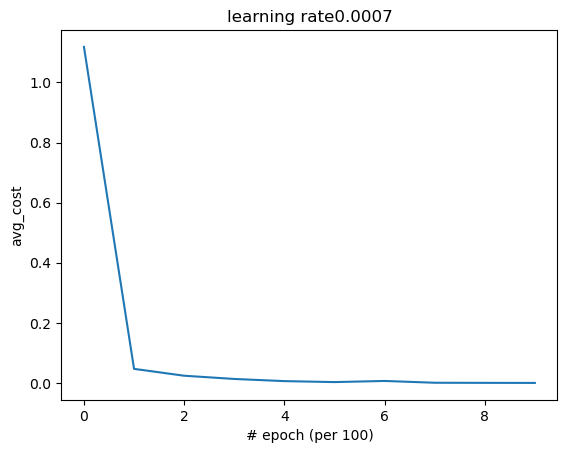

In [6]:
parameters=model(X_train,y_train,layers_dims,"Adam",learning_rate=0.0007,mini_batch_size=64,beta=0.9,beta1=0.9,beta2=0.999,epsilon=1e-8,num_epochs=1000,print_cost=True)

In [7]:

train_set_error= accuracy_of_model(X_train,y_train,parameters)
test_set_error= accuracy_of_model(X_test,y_test,parameters)

print(train_set_error)
print(test_set_error)

1.0
0.9824561403508771


In [8]:
import numpy as np
from tensorflow.keras.datasets import mnist

(X_train, y_train), (X_test, y_test) = mnist.load_data()


X_train= X_train / 255.0
X_test = X_test / 255.0


X_train = X_train.reshape(X_train.shape[0], -1).T 
X_test = X_test.reshape(X_test.shape[0], -1).T

y_train = y_train.reshape(1, -1)  
y_test = y_test.reshape(1, -1)


In [3]:
layers_dims=[784,128,64,32,10]

The number of training example is: 60000
The size of mini batch for each epoch is: 64
Cost after epoch 0: 0.2785, Train Accuracy: 0.9580
Cost after epoch 100: 0.0032, Train Accuracy: 0.9998
Cost after epoch 200: 0.0036, Train Accuracy: 0.9997
Cost after epoch 300: 0.0000, Train Accuracy: 1.0000
Cost after epoch 400: 0.0000, Train Accuracy: 1.0000
Cost after epoch 500: 0.0000, Train Accuracy: 1.0000
Cost after epoch 600: 0.0000, Train Accuracy: 1.0000
Cost after epoch 700: 0.0000, Train Accuracy: 1.0000
Cost after epoch 800: 0.0000, Train Accuracy: 1.0000
Cost after epoch 900: 0.0000, Train Accuracy: 1.0000


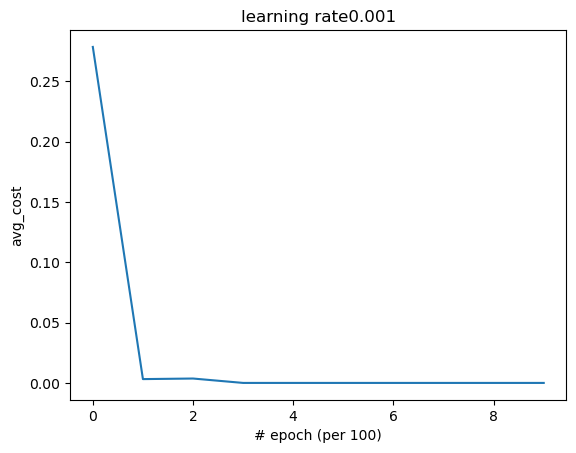

In [13]:
parameters=model(X_train,y_train,layers_dims,"Adam",learning_rate=1e-3,mini_batch_size=64,beta=0.9,beta1=0.9,beta2=0.999,epsilon=1e-8,num_epochs=1000,print_cost=True)

In [14]:
train_set_error= accuracy_of_model(X_train,y_train,parameters)
test_set_error= accuracy_of_model(X_test,y_test,parameters)

print(train_set_error)
print(test_set_error)

1.0
0.9839


In [15]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(X, y_true, parameters):
    y_pred_probs, _ = L_layer_deep_forward_layer(X, parameters)
    y_pred = np.argmax(y_pred_probs, axis=0)
    y_true_flat = y_true.flatten()

    cm = confusion_matrix(y_true_flat, y_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()


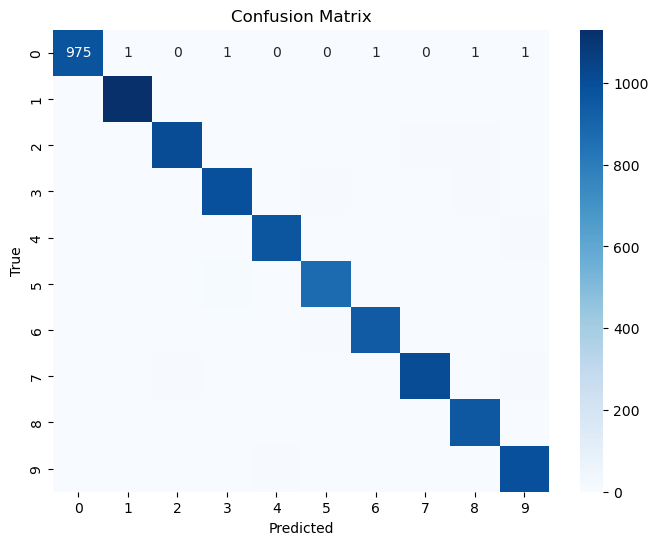

In [16]:
plot_confusion_matrix(X_test, y_test, parameters)


In [17]:
import matplotlib.pyplot as plt
import numpy as np

# Class labels for MNIST
class_names = [str(i) for i in range(10)]

def plot_correct_and_incorrect(X, y_true, parameters, correct_count=10, incorrect_count=10):
    """
    Plots 10 correct and 10 incorrect MNIST predictions.
    """
    y_probs, _ = L_layer_deep_forward_layer(X, parameters)
    y_pred = np.argmax(y_probs, axis=0)
    y_true_flat = y_true.flatten()

    correct_idx = np.where(y_pred == y_true_flat)[0]
    incorrect_idx = np.where(y_pred != y_true_flat)[0]

    # Plot correct predictions
    print("✅ Correct Predictions:")
    plt.figure(figsize=(15, 3))
    for i, idx in enumerate(correct_idx[:correct_count]):
        plt.subplot(1, correct_count, i + 1)
        plt.imshow(X[:, idx].reshape(28, 28), cmap="gray")
        plt.title(f"Pred: {class_names[y_pred[idx]]}\nTrue: {class_names[y_true_flat[idx]]}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

    # Plot incorrect predictions
    print("❌ Incorrect Predictions:")
    plt.figure(figsize=(15, 3))
    for i, idx in enumerate(incorrect_idx[:incorrect_count]):
        plt.subplot(1, incorrect_count, i + 1)
        plt.imshow(X[:, idx].reshape(28, 28), cmap="gray")
        plt.title(f"Pred: {class_names[y_pred[idx]]}\nTrue: {class_names[y_true_flat[idx]]}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()


✅ Correct Predictions:


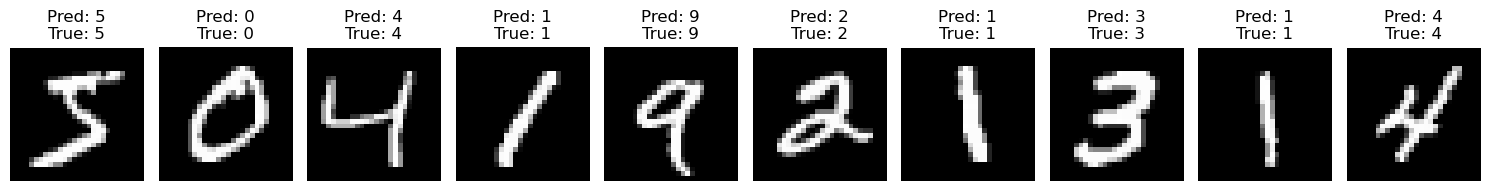

❌ Incorrect Predictions:


<Figure size 1500x300 with 0 Axes>

In [20]:
plot_correct_and_incorrect(X_train, y_train, parameters, correct_count=10, incorrect_count=10)

✅ Correct Predictions:


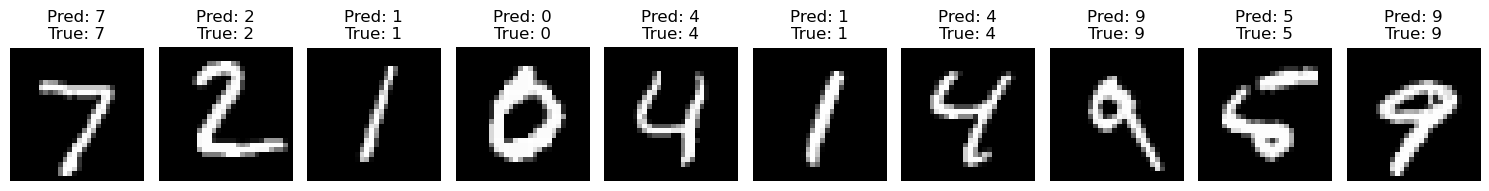

❌ Incorrect Predictions:


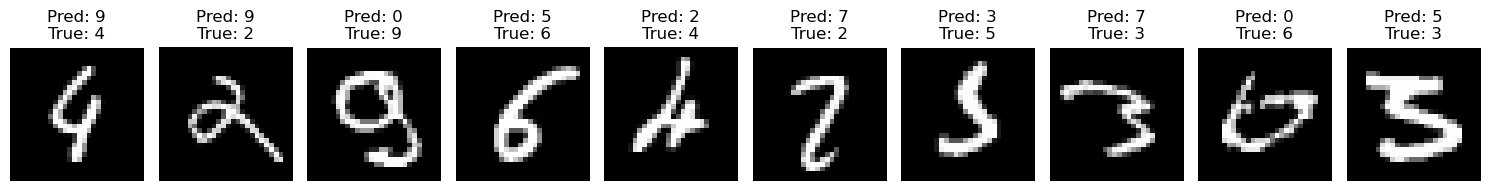

In [21]:
plot_correct_and_incorrect(X_test, y_test, parameters, correct_count=10, incorrect_count=10)

In [4]:
from tensorflow.keras.datasets import fashion_mnist
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()




X_train = X_train.reshape(X_train.shape[0], -1).T / 255.
X_test = X_test.reshape(X_test.shape[0], -1).T / 255.
y_train = y_train.reshape(1, -1)
y_test = y_test.reshape(1, -1)


The number of training example is: 60000
The size of mini batch for each epoch is: 64
Cost after epoch 0: 0.5160, Train Accuracy: 0.8532
Cost after epoch 100: 0.0517, Train Accuracy: 0.9848
Cost after epoch 200: 0.0258, Train Accuracy: 0.9943
Cost after epoch 300: 0.0237, Train Accuracy: 0.9951
Cost after epoch 400: 0.0140, Train Accuracy: 0.9959
Cost after epoch 500: 0.0159, Train Accuracy: 0.9972
Cost after epoch 600: 0.0019, Train Accuracy: 0.9969
Cost after epoch 700: 0.0167, Train Accuracy: 0.9994
Cost after epoch 800: 0.0106, Train Accuracy: 0.9966
Cost after epoch 900: 0.0011, Train Accuracy: 0.9989


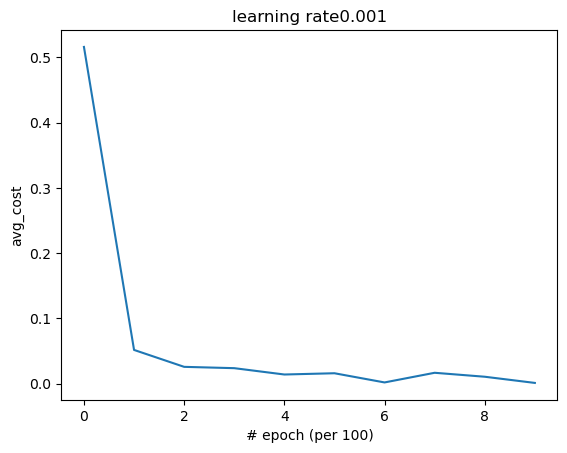

In [5]:
parameters=model(X_train,y_train,layers_dims,"Adam",learning_rate=0.001,mini_batch_size=64,beta=0.9,beta1=0.9,beta2=0.999,epsilon=1e-8,num_epochs=1000,print_cost=True)

In [6]:
train_set_error= accuracy_of_model(X_train,y_train,parameters)
test_set_error= accuracy_of_model(X_test,y_test,parameters)

print(train_set_error)
print(test_set_error)

0.9995666666666667
0.8906


In [7]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusion_matrix(X, y_true, parameters):
    y_probs, _ = L_layer_deep_forward_layer(X, parameters)
    y_pred = np.argmax(y_probs, axis=0)
    y_true = y_true.flatten()
    
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.show()


In [9]:
def plot_incorrect_predictions(X, y_true, parameters, class_names):
    y_probs, _ = L_layer_deep_forward_layer(X, parameters)
    y_pred = np.argmax(y_probs, axis=0)
    y_true = y_true.flatten()
    
    incorrect_indices = np.where(y_pred != y_true)[0][:10]
    
    plt.figure(figsize=(12, 6))
    for i, idx in enumerate(incorrect_indices):
        plt.subplot(2, 5, i + 1)
        image = X[:, idx].reshape(28, 28) 
        plt.imshow(image, cmap='gray')
        plt.title(f"True: {class_names[y_true[idx]]}\nPred: {class_names[y_pred[idx]]}")
        plt.axis('off')
    plt.suptitle("Top 10 Incorrect Predictions", fontsize=16)
    plt.tight_layout()
    plt.show()


In [10]:
def plot_correct_predictions(X, y_true, parameters, class_names):
    y_probs, _ = L_layer_deep_forward_layer(X, parameters)
    y_pred = np.argmax(y_probs, axis=0)
    y_true = y_true.flatten()
    
    correct_indices = np.where(y_pred == y_true)[0][:10]
    
    plt.figure(figsize=(12, 6))
    for i, idx in enumerate(correct_indices):
        plt.subplot(2, 5, i + 1)
        image = X[:, idx].reshape(28, 28)
        plt.imshow(image, cmap='gray')
        plt.title(f"Label: {class_names[y_true[idx]]}")
        plt.axis('off')
    plt.suptitle("Top 10 Correct Predictions", fontsize=16)
    plt.tight_layout()
    plt.show()


In [11]:
class_names = [
    'T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
    'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'
]
